<a href="https://colab.research.google.com/github/KevinTheRainmaker/Recommendation_Algorithms/blob/main/colab/fastcampus/Compare_the_CFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 협업필터링 성능 비교 분석하기
## Matrix Factorization

- Train Matrix Factorization from Scratch
- Code Source: [albertauyeung/matrix-factorization-in-python](https://github.com/albertauyeung/matrix-factorization-in-python/blob/master/mf.py)
- SGD 이용 MF 기법
![image](https://user-images.githubusercontent.com/76294398/142833012-f1033b2d-9cab-4394-ab4b-fc73128b8994.png)



## Load Dataset & Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [4]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [5]:
# Small dataset
train_df = train_df[:1000]
print(train_df.shape)

(1000, 4)


## Create Sparse Matrix


In [6]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'moviedId'

# fill sparse matrix with zero
sparse_matrix.fillna(0, inplace=True)

# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [7]:
# dataframe to numpy
sparse_matrix = sparse_matrix.to_numpy()
sparse_matrix_withmovie = sparse_matrix_withmovie.to_numpy()
sparse_matrix_withuser = sparse_matrix_withuser.to_numpy()

sparse_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Implement Matrix Factorization

In [47]:
class MF():
  def __init__(self, R, K, alpha, beta, iterations):
    '''
    Perform Matrix Factorization to predict empty
    entries in a matrix.

    Arguments
    - R (ndarray)   : user-item rating matrix
    - K (int)       : number of latent dimensions
    - alpha (float) : learning rate
    - beta (float)  : regularization parameter
    '''

    self.R = R
    self.num_users, self.num_items = R.shape
    self.K = K
    self.alpha = alpha
    self.beta = beta # lambda
    self.iterations = iterations # epochs

  def train(self):
    # Initialize user and item latent feature matrice
    # Update later using SGD
    self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K)) # scale == 표준편차 -> 1/number of latent dimensions
    self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))

    # Initialize the biases
    self.b_u = np.zeros(self.num_users) # deviation of user u about entire users
    self.b_i = np.zeros(self.num_items) # deviation of item i about entire items
    self.b = np.mean(self.R[np.where(self.R != 0)]) # average rating of all items == $\mu$

    # Create a list of training samples
    self.samples = [
                    (i, j, self.R[i,j])
                    for i in range(self.num_users)
                    for j in range(self.num_items)
                    if self.R[i,j] > 0
    ]

    # Perform Stochastic Gradient Descent(SGD) for number of iterations
    training_process = []
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      mse = self.mse()
      training_process.append((i,mse))
      # if(i+1) % 10 ==0:
      print('Iteration: %d ; error(MSE) = %.4f' % (i+1, mse))

    return training_process

  def mse(self):
    '''
    A function to compute the total Mean Squared Error
    '''
    xs, ys = self.R.nonzero()
    predicted = self.full_matrix()
    error = 0
    for x, y in zip(xs, ys):
      error += pow(self.R[x,y] - predicted[x,y], 2)
    return np.sqrt(error)

  def sgd(self):
    '''
    Perform Stochastic Gradient Descent
    '''
    for i, j, r in self.samples:
      # Compute prediction and error
      prediction = self.get_rating(i,j)
      e = (r-prediction)

      # Update biases
      self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
      self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

      # Create copy of row of P since we need to update it but use older values for update on Q
      P_i = self.P[i, :][:]

      # Update user and item latent feature matrices
      self.P[i, :] += self.alpha * (e * self.Q[j,:] - self.beta * self.P[i,:])
      self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j, :])

  def get_rating(self, i, j):
    '''
    Get the predicted rating of user i and item j
    '''
    prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
    return prediction

  # helper function
  def full_matrix(self):
    '''
    Compute the full matrix using the resultant biases, P & Q
    '''
    return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

## Train Matrix Factorization

In [48]:
sparse_matrix.shape

(799, 347)

In [49]:
mf = MF(sparse_matrix, K=50, alpha=0.1, beta=0.01, iterations=20)

In [50]:
training_process = mf.train()

Iteration: 1 ; error(MSE) = 25.1516
Iteration: 2 ; error(MSE) = 21.4216
Iteration: 3 ; error(MSE) = 18.7693
Iteration: 4 ; error(MSE) = 16.5651
Iteration: 5 ; error(MSE) = 14.7382
Iteration: 6 ; error(MSE) = 13.0546
Iteration: 7 ; error(MSE) = 11.5328
Iteration: 8 ; error(MSE) = 10.1499
Iteration: 9 ; error(MSE) = 8.8890
Iteration: 10 ; error(MSE) = 7.7849
Iteration: 11 ; error(MSE) = 6.8033
Iteration: 12 ; error(MSE) = 5.9478
Iteration: 13 ; error(MSE) = 5.2100
Iteration: 14 ; error(MSE) = 4.5780
Iteration: 15 ; error(MSE) = 4.0320
Iteration: 16 ; error(MSE) = 3.5652
Iteration: 17 ; error(MSE) = 3.1704
Iteration: 18 ; error(MSE) = 2.8287
Iteration: 19 ; error(MSE) = 2.5417
Iteration: 20 ; error(MSE) = 2.2947


In [46]:
mf.full_matrix()

array([[4.78514137, 4.76598748, 4.43101176, ..., 3.87741203, 3.75630101,
        3.94117071],
       [4.19690914, 4.14162595, 3.86853084, ..., 3.31080566, 3.08039991,
        3.43570658],
       [3.7213288 , 3.66658312, 3.39489012, ..., 2.83147693, 2.63312459,
        2.97922276],
       ...,
       [4.10892812, 4.0484573 , 3.77126079, ..., 3.21218742, 3.01176114,
        3.37450302],
       [4.39481632, 4.3393295 , 4.06522125, ..., 3.49996517, 3.27711073,
        3.68152898],
       [3.86821334, 3.80998575, 3.54007449, ..., 2.97387597, 2.72967356,
        3.13633572]])

### Visualize

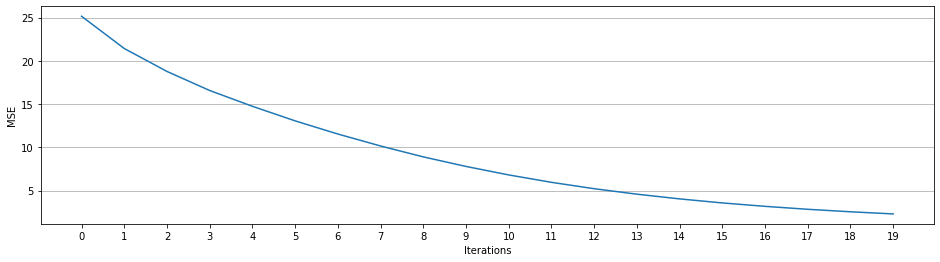

In [53]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16,4))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid(axis='y')